# Topic Modeling: ADHD

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('adhd.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,1.365320e+18,52,"Sheffield, England","❤Sal / UK\r\r\n🧡Player of games, Master of non...",10/27/2021 12:40,Saw GP today and we went through stuff and I t...,NaN
1,5.363879e+07,1667,UK,27y/o nonbinary creator. They/Them. disabled. ...,10/27/2021 12:40,My ADHD Graveyard | Officially Diagnosed and A...,NaN
2,1.329360e+18,12,"England, United Kingdom",38. A diagnosis referral is hard in the UK. Se...,10/27/2021 12:37,Have there been any studies of adults or child...,"['askADHD', 'ADHD']"
3,1.242600e+18,8,"West Hempstead, NY",OrganizeU4Life is making an impact on the live...,10/27/2021 12:35,Environmental factors don’t directly cause ADH...,NaN
4,1.429030e+18,48,España,"🔞. Mainly NSFW. He/Him. 28. Gay, Single and Lo...",10/27/2021 12:33,Here in Spain we celebrate the national day of...,['ADHD']


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=len(data)/5, \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics,random_state=np.random.RandomState(1000),\
                       passes=20, eval_every=1)

# show keywords
print(lda_model.print_topics())

[(0, '0.017*"think_might" + 0.017*"planner" + 0.016*"many_different" + 0.016*"started_hyperfocus" + 0.016*"organisation_planner" + 0.016*"adhdawareness_adhdperson" + 0.016*"planner_journal" + 0.016*"adh_adhdtwitter" + 0.016*"already_curious" + 0.014*"adhdtwitter"'), (1, '0.099*"what" + 0.095*"change_knew" + 0.065*"would" + 0.063*"find_started" + 0.063*"asking_question" + 0.063*"exercise_nutrition" + 0.063*"important_sleep" + 0.033*"sleep" + 0.033*"question" + 0.033*"important"'), (2, '0.127*"meet_brain" + 0.085*"have_heard" + 0.085*"learn_below" + 0.085*"teamadhd_lifeinadhd" + 0.044*"adhdawareness" + 0.043*"learn" + 0.043*"brain" + 0.043*"have" + 0.043*"teamadhd" + 0.043*"heard"'), (3, '0.081*"job" + 0.044*"people" + 0.042*"feel" + 0.041*"with" + 0.041*"there" + 0.041*"body" + 0.041*"room" + 0.041*"human" + 0.041*"thinking" + 0.041*"though"'), (4, '0.058*"especially_part" + 0.058*"life_diagnosed" + 0.058*"never_feeling" + 0.058*"mourning_thanks" + 0.058*"kitchen_listening" + 0.035*"dia

### We check the accuracy of our model with coherence scores (through CV, and UMass)

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.8787744108297844


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -1.972618276920683


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=11):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=np.random.RandomState(1000))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.9022027314395564,
 0.7439260843026899,
 0.623230656684578,
 0.5980943996996706,
 0.5630455842435845,
 0.5602117520442838,
 0.5955873575833338,
 0.5803712763712569,
 0.5477768967133896]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 2.

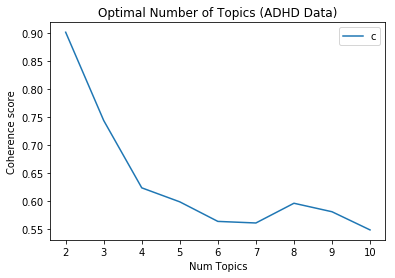

In [16]:
limit=11; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (ADHD Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.244134  0.0       1        1  53.538253
0     -0.244134  0.0       2        1  46.461747, topic_info=                                               Term         Freq        Total  \
term                                                                            
481                                      meet_brain  4786.000000  4786.000000   
479                                     learn_below  3189.000000  3189.000000   
482                             teamadhd_lifeinadhd  3190.000000  3190.000000   
475                                      have_heard  3205.000000  3205.000000   
132                                            what  3248.000000  3248.000000   
1050                                    change_knew  2628.000000  2628.000000   
478                                           learn  1814.000000  1814.000000   
12                                    adhdawareness  1851.000000  1851.000000   
148                                        teamadhd  1667.000000  1667.000000   
32                                             have  1675.000000  1675.000000   
480                                            meet  1645.000000  1645.000000   
474                                           below  1601.000000  1601.000000   
410                                          vortex  1597.000000  1597.000000   
407                                  frontal_vortex  1600.000000  1600.000000   
230                                         frontal  1603.000000  1603.000000   
408                                      lifeinadhd  1598.000000  1598.000000   
476                       have_heard_frontal_vortex  1594.000000  1594.000000   
483                 teamadhd_lifeinadhd_learn_below  1594.000000  1594.000000   
477                                           heard  1677.000000  1677.000000   
64                                            would  1938.000000  1938.000000   
1052                                   find_started  1753.000000  1753.000000   
1051                             exercise_nutrition  1753.000000  1753.000000   
1049                                asking_question  1752.000000  1752.000000   
1054                                important_sleep  1749.000000  1749.000000   
183                                           brain  1858.000000  1858.000000   
169                                       important  1237.000000  1237.000000   
210                                        question  1126.000000  1126.000000   
179                                         started  1228.000000  1228.000000   
424                                           sleep  1080.000000  1080.000000   
435                                            find  1159.000000  1159.000000   
...                                             ...          ...          ...   
475                                      have_heard  3183.526312  3205.962939   
1140                                adulthood_learn   122.117266   123.269451   
1144                   disorder_prevent_growth_sign   122.117266   123.269451   
1146                                       hcpspace   122.117266   123.269451   
1148                  often_begin_childhood_persist   122.117266   123.269451   
1149  treatment_option_childhood_neurodevelopmental   122.117266   123.269451   
989                                      video_game   121.946783   123.247199   
1021                                        persist   122.202611   123.508048   
1063                                          begin   122.914022   124.249416   
477                                           heard  1656.967899  1677.846980   
12                                    adhdawareness  1827.824061  1851.191295   
81                                        childhood   267.380552   271.630324   
183                                           brain  1743.589390  1858.132212   
202                                

In [18]:
pyLDAvis.save_html(LDAvis_viz, 'ADHD Visualization.html')

### We interpret the topics based on the keywords

In [19]:
print('1: Contact Awareness')
print('2: Treatment/Factors')

1: Contact Awareness
2: Treatment/Factors
